# Imports

## Libraries

In [7]:
import geopandas as gpd
import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import Point
from functions import * 

## Data

In [8]:
provinces_gdf = gpd.read_file("../data/provinces_gdf.geojson", driver='geojson')

# Centroids

## Calculate centroid for each region in italy 

There are *two* centroids I'll be plotting: one is a **geographic centroid** which is the true center of a regional unit. The other is a **"weighted mean population centroid,"** which shows the center of the *population* in a regional unit. 

- Steps to getting the population weighted mean centroid
    - find geographic centroid for each province 
    - group the provinces into a larger unit (macroregion, cultural region, all of italy)
    - assign a weight (i.e.: the population) to each province
    - find the numerator: multiply each latitude and longitude by the weight 
    - find the denominator: multiply a weight by the number of units in the smaller geometry
    - sum up all of the numerators and denominators for a given regional unit
    - divide the numerator by the denominator
    - plot results next to the geographic centroid

## Regions

### Getting Region Geometries

In [9]:
region_geometries = provinces_gdf.dissolve(by='Region')

### Finding Geographic centroid

In [10]:
region_geo_centroids = geographic_centroid_gdf('Region')

### Getting Weighted population centroids

In [11]:
region_pop_weighted_gdf = find_weighted_centroids("Region")

### Plot 

The green dot(s) represent the weighted mean population centroid 
    while the black dots represent the geographic centroid


<AxesSubplot:>

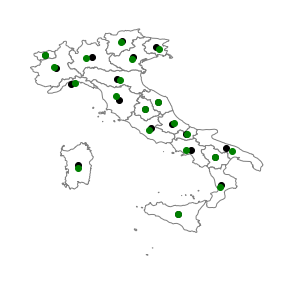

In [12]:
plot_both_centroids(region_geometries, region_geo_centroids, region_pop_weighted_gdf)

### Which regional centers are furthest/closest to the geographic center?

**SMALLEST DISTANCE**: Aosta Valley (upper left-most region) has the lowest distance between centroids since it has only one province in the region

In [ ]:
# finding largest distance
region_pop_weighted_gdf['Geographic_centroid'] = region_geo_centroids.geometry
region_pop_weighted_gdf['Distance_bn_centroids'] = region_pop_weighted_gdf.geometry.distance(
    region_pop_weighted_gdf['Geographic_centroid'])
max_distance = region_pop_weighted_gdf['Distance_bn_centroids'].max()
region_pop_weighted_gdf[region_pop_weighted_gdf['Distance_bn_centroids'] == max_distance]

**LARGEST DISTANCE**: Apulia (lower right-most region) has the furthest distance between centroids.

## Macroregions

### Getting Macroregion Geometries

In [13]:
macroregion_geometries = provinces_gdf.dissolve(by='Macroregion')

### Finding Geographic centroid

In [14]:
macroregion_geo_centroids = geographic_centroid_gdf('Macroregion')

### Getting Weighted population centroids

In [15]:
macroregion_pop_weighted_gdf = find_weighted_centroids("Macroregion")

### Plot 

The green dot(s) represent the weighted mean population centroid 
    while the black dots represent the geographic centroid


<AxesSubplot:>

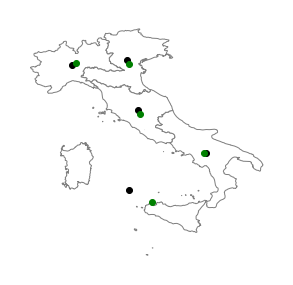

In [16]:
plot_both_centroids(macroregion_geometries, macroregion_geo_centroids, macroregion_pop_weighted_gdf)

#### more ppl in sicily than sardinia?

In [19]:
prov_pop_sum = provinces_gdf.groupby('Region')['Population'].sum()
print(f"The population of Sicily: {prov_pop_sum['Sicily']}")
print(f"The population of Sardinia: {prov_pop_sum['Sardinia']}")
print(f"{prov_pop_sum['Sicily'] - prov_pop_sum['Sardinia']} more people live in Sicily than Sardinia")

The population of Sicily: 4999891
The population of Sardinia: 1780437
3219454 more people live in Sicily than Sardinia


## Cultural Regions

### Getting Cultural Geometries

In [20]:
cultural_region_geometries = provinces_gdf.dissolve(by='Cultural_region')

### Finding Geographic centroid

In [21]:
cultural_region_geo_centroids = geographic_centroid_gdf('Cultural_region')

### Getting Weighted population centroids

In [22]:
cultural_region_pop_weighted_gdf = find_weighted_centroids("Cultural_region")

### Plot 

The green dot(s) represent the weighted mean population centroid 
    while the black dots represent the geographic centroid


<AxesSubplot:>

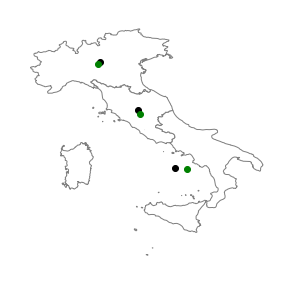

In [23]:
plot_both_centroids(cultural_region_geometries, cultural_region_geo_centroids, cultural_region_pop_weighted_gdf)

## All of Italy

### Getting Italy's Geometry

In [24]:
italy_geometry = provinces_gdf.dissolve(by='Country')

### Finding Geographic centroid

In [25]:
italy_geo_centroids = geographic_centroid_gdf('Country')

### Getting Weighted population centroids

In [26]:
italy_pop_weighted_gdf = find_weighted_centroids("Country")

### Plot 

The green dot(s) represent the weighted mean population centroid 
    while the black dots represent the geographic centroid


<AxesSubplot:>

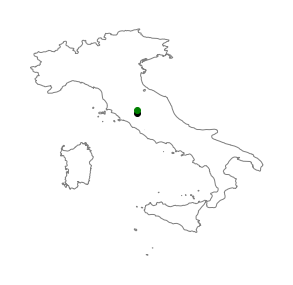

In [27]:
plot_both_centroids(italy_geometry, italy_geo_centroids, italy_pop_weighted_gdf)

#### Which region do these points land in?

In [28]:
italy_geo_center_point = italy_geo_centroids.geometry[0]
italy_pop_centroid = italy_pop_weighted_gdf.geometry[0]

In [29]:
# the mean population center of italy is within perugia
for index,x in provinces_gdf.iterrows():
    if x['Macroregion'] == 'Centre':
        if italy_geo_center_point.within(x['geometry']):
            print(f"Geographic center of italy is in the province of: {x['name']}")
        if italy_pop_centroid.within(x['geometry']):
            print(f"Population center of italy is in the province of: {x['name']}")

Population center of italy is in the province of: Perugia
Geographic center of italy is in the province of: Terni


In [30]:
terni_gdf = provinces_gdf[provinces_gdf['Province'] == 'Terni']
perugia_gdf = provinces_gdf[provinces_gdf['Province'] == 'Perugia']

<AxesSubplot:>

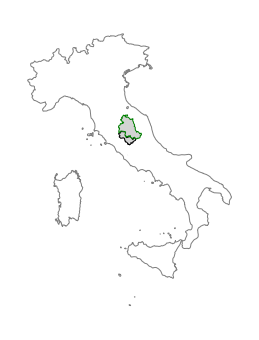

In [33]:
# plotting the regions
# green is population center while black is geographic center
# Both are very close, but they happen to fall in two different provinces
ax1 = gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', figsize=(6,6))
terni_gdf.plot(ax=ax1, color='lightgrey', edgecolor = 'black', figsize=(6,6))
perugia_gdf.plot(ax=ax1, color='lightgrey', edgecolor = 'green', figsize=(6,6))